# Load data

In [1]:
%matplotlib inline

In [2]:
import numpy as np 
import sklearn 
import scipy.misc
import matplotlib.pyplot as plt

In [11]:
# loading data
x_train = np.loadtxt("data/train_x.csv", delimiter=",")
y_train = np.loadtxt("data/train_y.csv", delimiter=",")
x_test = np.loadtxt("data/test_x.csv", delimiter=",")
print("Done")

Done


In [12]:
# encode y_train data in one-hot encoding
y_train_one_hot = [[0 for i in range(10)] for i in range(len(y_train))]
for i in range(len(y_train)):
    y_train_one_hot[i][int(y_train[i])] = 1

y_train_one_hot = np.array(y_train_one_hot)

In [19]:
def show_img(img):
    plt.close()
    plt.imshow(img, cmap='gray_r')
    plt.show()

x_train_reshaped = x_train.reshape(-1, 64, 64)
y_train_reshaped = y_train.reshape(-1, 1) 
x_test_reshaped = x_test.reshape(-1, 64, 64)


In [5]:
def clean_data(x):
    """
    Because the only thing that matters is the numbers in the picture, which are black, 
    we recode the pixels as 1 if the pixel was 255 and 0 otherwise. To reduce noise and to
    reduce overflow/underflow in later stages.
    """
    new_data = []
    for row in x:
        new_row = []
        for pixel in row:
            if pixel == 255:
                new_row.append(1)
            else:
                new_row.append(0)
        new_data.append(new_row)
    return np.array(new_data)



## Split training data into train / valid sets

In [20]:
from sklearn.model_selection import train_test_split
x_train_s, x_valid_s, y_train_s, y_valid_s = train_test_split(x_train, y_train_one_hot, train_size=0.8, test_size=0.2)
data = {
    "x_train": clean_data(x_train_s),
    "x_valid": clean_data(x_valid_s),
    "y_train": y_train_s,
    "y_valid": y_valid_s
}

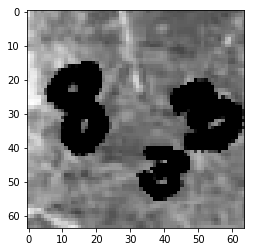

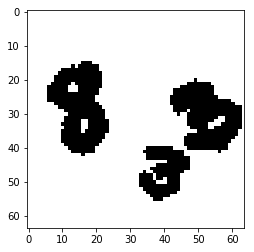

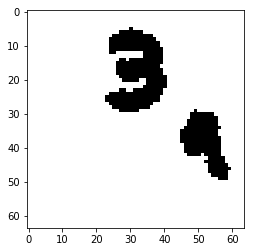

In [22]:
# x_cleaned_reshaped = data["x_train"].reshape(-1, 64, 64)

# x_train_s_reshaped = x_train_s.reshape(-1, 64, 64)
# show_img(x_train_s_reshaped[0])
# show_img(x_cleaned_reshaped[0])
# x_v_cleaned_reshaped = data["x_valid"].reshape(-1, 64, 64)
# show_img(x_v_cleaned_reshaped[0])

# Baseline Linear Classifier: Linear SVM

In [23]:
from sklearn import metrics
from sklearn.svm import LinearSVC

(40000, 4096)

In [25]:
def baseline_linear_svm(data):
    """
    Using out-of-the-box linear SVM to classify data
    """
    clf = LinearSVC()
    
    y_pred = clf.fit(data["x_train"], data["y_train"]).predict(data["x_valid"])
    print(y_pred)
    return metrics.accuracy_score(data["y_valid"], y_pred, average="macro"), y_pred
    
# score, y_pred = baseline_linear_svm(data)
# print(score)

# Neural Network

In [26]:
from scipy.special import expit

In [118]:
def sigmoid(x):
    """
    sigmoid function
    """
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    """
    derivative of sigmoid
    """
    return x * (1. - x)

def tanh(x):
    """
    tanh function
    """
    return np.tanh(x)

def d_tanh(x):
    """
    derivative of tanh
    """
    return 1 - x*x

def relu(x):
    """
    relu function
    """
    return np.log(1 + np.exp(x))

def d_relu(x):
    """
    derivative of relu
    """
    return np.exp(x) / 1. + np.exp(x)

def softmax(x):
    """
    softmax classifier
    40k x 10
    """
    e = np.exp(x)
    e_sum = np.sum(e, axis=1)
    y = []
    for i in range(len(e)):
        y.append(e[i]/e_sum[i])
    return np.array(y)

def d_softmax(output, y):
    """
    d loss / d output
    """
    return output - y

def log_loss(output):
    loss = []
    for i in range(len(output)):
        log_loss_sum = []
        for j in range(10):
            log_loss_sum.append(np.log(output[i][j]))
        loss.append(log_loss_sum)
    return np.array(loss)
        


In [59]:
class Layer:
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="sigmoid"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "sigmoid":
            self.activation_func = expit
            self.d_activation_func = self.d_sigmoid
            
        else:
            pass
        
    def feedforward(self, x):
        """
        return the predictions (represented by a probability)
        """
        # calculate stuff
        self.input = x
        before_activation = np.dot(x, self.w)
        self.output = self.activation_func(before_activation) 
        self.derivative = self.d_activation_func(before_activation)
        
        
        
        # if there's a next layer
        if self.next:
            passed_output = []
            # add bias to the end of each row of self.output
            try:
                passed_output = np.append(self.output, np.ones((self.output.shape[0], 1)), axis=-1)
            except ValueError:
                passed_output = np.append(self.output, 1) 
            
            # call next layer's feedforward step
            self.next.feedforward(passed_output)

        
    def backprop(self, prev_deltas):
        """
        compute derivatives and adjust w
        """ 
#         deltas = np.dot(self.derivative, prev_deltas )
        deltas = prev_deltas * self.derivative
        if self.prev:
            self.prev.backprop(np.dot(self.w[:-1], deltas))
        self.w = self.w - (self.learning_rate * np.dot(self.input.T, deltas))
    
        
    def sigmoid(self, x):
        """
        sigmoid function
        """
        return 1 / (1 + np.exp(-x))

    def d_sigmoid(self, x):
        """
        derivative of sigmoid
        """
        return x * (1. - x)
   
    
class OutputLayer(Layer):
    def __init__(self, input_rows, input_cols, learning_rate=0.01, num_nodes=200, activation_func="softmax"):
        self.input_rows = input_rows
        self.input_cols = input_cols
        self.num_nodes = num_nodes
        self.next = None
        self.prev = None
        input_range = 1.0 / input_rows ** (1/2)
        self.w = np.random.normal(loc=0, scale=input_range, size=(self.input_cols,num_nodes))
        self.learning_rate = learning_rate
        
        if activation_func == "softmax":
            self.activation_func = self.softmax
            self.backprop_func = lambda x, target: x - target
            
        elif activation_func == "sigmoid":
            self.activation_func = self.sigmoid
            self.backprop_func = lambda x, target: self.d_sigmoid(x) * (x - target)
            
        else:
            pass
        
        # Value is unused.
        self.d_activation_func = lambda x: None
     
    def backprop(self, targets):
        deltas = self.backprop_func(self.output, targets)
        self.prev.backprop(np.dot(self.w[:-1], deltas.T).T)
        self.w = self.w - self.learning_rate * np.dot(self.input.T, deltas)
        
    
    def softmax(self, x):
#         e = np.exp(x - np.amax(x))
#         dist = e / np.sum(e)
#         return dist
        e = np.exp(x)
        e_sum = np.sum(e, axis=1)
        y = []
        for i in range(len(e)):
            y.append(e[i]/e_sum[i])
        return np.array(y)
        
    
class NeuralNet:
    def __init__(self, learning_rate, num_epochs):
        self.first = None
        self.last = None
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        
    def add_layer(self, layer):
        """
        Add layer to the end
        """
        if not self.first:
            self.first = layer
            self.last = layer
            
        else:
            temp = self.last
            temp.next = layer
            layer.prev = temp
            self.last = layer
            
    def fit(self, x_train, y_train):
        x_input = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=-1)
        
        for i in range(self.num_epochs):
            print(i, "before feedforward & backprop")
            print(self.first.w)
            print(self.first.next.w)
            print(self.last.w)

            
            for j in range(0, len(x_input), 1000):
                self.first.feedforward(x_input[j:j+1000])
                self.last.backprop(y_train[j:j+1000])
            
                
                print(i, "after feedforward & backprop")
                print(self.first.w)
                print(self.first.next.w)
                print(self.last.w)
                
                
    def predict(self, x):
        x_input = np.append(x, np.ones((x.shape[0], 1)), axis=-1)
        self.first.feedforward(x_input)
        return self.last.output
    
    def from_one_hot(self, x):
        y = []
        for row in x:
            y.append(np.argmax(row))
            
        return y


x_tr = data["x_train"]
y_tr = data["y_train"]

neural_net = NeuralNet(1e-12, 10)

neural_net.add_layer(Layer(x_tr.shape[0], x_tr.shape[1] + 1, 1e-12, 300))
# neural_net.add_layer(Layer(x_tr.shape[0], 300 + 1, 1e-12, 200))
neural_net.add_layer(OutputLayer(x_tr.shape[0], 300 + 1, 1e-12, 10))

neural_net.fit(x_tr, y_tr)
predict_y = neural_net.predict(data["x_valid"])
print("Done")
        
        
        

0 before feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612034e-03  -4.31546640e-03  -2.06967799e-03 ...,   3.41518608e-03
    1.60833357e-03  -2.37574560e-03]
 [ -4.98140737e-03   5.80192066e-03  -1.23238223e-03 ...,   6.32372283e-04
    8.74602637e-03   3.35678072e-03]
 [  1.15625731e-03  -1.41809466e-02  -9.49776720e-03 ...,   8.55241030e-03
    2.84703897e-03  -1.18360816e-02]
 ..., 
 [  2.23427794e-03   1.01471844e-04   1.90748306e-03 ...,  -2.31007361e-03
   -2.69793496e-03   3.88555326e-03]
 [  1.29916762

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612037e-03  -4.31546637e-03  -2.06967802e-03 ...,   3.41518608e-03
    1.60833358e-03  -2.37574557e-03]
 [ -4.98140735e-03   5.80192069e-03  -1.23238226e-03 ...,   6.32372275e-04
    8.74602638e-03   3.35678076e-03]
 [  1.15625734e-03  -1.41809466e-02  -9.49776723e-03 ...,   8.55241030e-03
    2.84703898e-03  -1.18360815e-02]
 ..., 
 [  2.23427797e-03   1.01471875e-04   1.90748303e-03 ...,  -2.31007362e-03
   -2.69793495e-03   3.88555330e-03]
 [  1.29916764e

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612037e-03  -4.31546635e-03  -2.06967804e-03 ...,   3.41518611e-03
    1.60833358e-03  -2.37574557e-03]
 [ -4.98140735e-03   5.80192071e-03  -1.23238228e-03 ...,   6.32372309e-04
    8.74602639e-03   3.35678075e-03]
 [  1.15625734e-03  -1.41809466e-02  -9.49776725e-03 ...,   8.55241033e-03
    2.84703899e-03  -1.18360815e-02]
 ..., 
 [  2.23427797e-03   1.01471893e-04   1.90748300e-03 ...,  -2.31007359e-03
   -2.69793495e-03   3.88555330e-03]
 [  1.29916765e

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612038e-03  -4.31546632e-03  -2.06967804e-03 ...,   3.41518612e-03
    1.60833359e-03  -2.37574556e-03]
 [ -4.98140734e-03   5.80192074e-03  -1.23238229e-03 ...,   6.32372319e-04
    8.74602639e-03   3.35678076e-03]
 [  1.15625735e-03  -1.41809466e-02  -9.49776725e-03 ...,   8.55241034e-03
    2.84703899e-03  -1.18360815e-02]
 ..., 
 [  2.23427798e-03   1.01471917e-04   1.90748300e-03 ...,  -2.31007358e-03
   -2.69793494e-03   3.88555331e-03]
 [  1.29916765e

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612039e-03  -4.31546628e-03  -2.06967807e-03 ...,   3.41518614e-03
    1.60833360e-03  -2.37574555e-03]
 [ -4.98140733e-03   5.80192078e-03  -1.23238232e-03 ...,   6.32372345e-04
    8.74602641e-03   3.35678077e-03]
 [  1.15625737e-03  -1.41809465e-02  -9.49776728e-03 ...,   8.55241037e-03
    2.84703901e-03  -1.18360815e-02]
 ..., 
 [  2.23427800e-03   1.01471963e-04   1.90748297e-03 ...,  -2.31007355e-03
   -2.69793492e-03   3.88555332e-03]
 [  1.29916766e

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612040e-03  -4.31546622e-03  -2.06967811e-03 ...,   3.41518615e-03
    1.60833361e-03  -2.37574555e-03]
 [ -4.98140732e-03   5.80192083e-03  -1.23238236e-03 ...,   6.32372357e-04
    8.74602642e-03   3.35678078e-03]
 [  1.15625738e-03  -1.41809465e-02  -9.49776732e-03 ...,   8.55241038e-03
    2.84703902e-03  -1.18360815e-02]
 ..., 
 [  2.23427801e-03   1.01472012e-04   1.90748293e-03 ...,  -2.31007354e-03
   -2.69793491e-03   3.88555333e-03]
 [  1.29916767e

0 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612044e-03  -4.31546618e-03  -2.06967816e-03 ...,   3.41518618e-03
    1.60833362e-03  -2.37574552e-03]
 [ -4.98140728e-03   5.80192088e-03  -1.23238241e-03 ...,   6.32372385e-04
    8.74602642e-03   3.35678081e-03]
 [  1.15625742e-03  -1.41809464e-02  -9.49776737e-03 ...,   8.55241041e-03
    2.84703903e-03  -1.18360815e-02]
 ..., 
 [  2.23427805e-03   1.01472057e-04   1.90748288e-03 ...,  -2.31007351e-03
   -2.69793491e-03   3.88555336e-03]
 [  1.29916771e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612048e-03  -4.31546614e-03  -2.06967820e-03 ...,   3.41518617e-03
    1.60833362e-03  -2.37574550e-03]
 [ -4.98140724e-03   5.80192092e-03  -1.23238245e-03 ...,   6.32372376e-04
    8.74602643e-03   3.35678083e-03]
 [  1.15625746e-03  -1.41809464e-02  -9.49776741e-03 ...,   8.55241040e-03
    2.84703903e-03  -1.18360815e-02]
 ..., 
 [  2.23427809e-03   1.01472095e-04   1.90748284e-03 ...,  -2.31007352e-03
   -2.69793490e-03   3.88555338e-03]
 [  1.29916775e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612049e-03  -4.31546611e-03  -2.06967822e-03 ...,   3.41518620e-03
    1.60833363e-03  -2.37574548e-03]
 [ -4.98140724e-03   5.80192095e-03  -1.23238247e-03 ...,   6.32372399e-04
    8.74602644e-03   3.35678085e-03]
 [  1.15625748e-03  -1.41809464e-02  -9.49776743e-03 ...,   8.55241043e-03
    2.84703904e-03  -1.18360814e-02]
 ..., 
 [  2.23427810e-03   1.01472117e-04   1.90748281e-03 ...,  -2.31007349e-03
   -2.69793488e-03   3.88555340e-03]
 [  1.29916776e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612049e-03  -4.31546608e-03  -2.06967823e-03 ...,   3.41518621e-03
    1.60833363e-03  -2.37574548e-03]
 [ -4.98140723e-03   5.80192098e-03  -1.23238247e-03 ...,   6.32372412e-04
    8.74602644e-03   3.35678085e-03]
 [  1.15625748e-03  -1.41809463e-02  -9.49776744e-03 ...,   8.55241044e-03
    2.84703905e-03  -1.18360814e-02]
 ..., 
 [  2.23427811e-03   1.01472152e-04   1.90748281e-03 ...,  -2.31007348e-03
   -2.69793488e-03   3.88555340e-03]
 [  1.29916776e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612050e-03  -4.31546605e-03  -2.06967824e-03 ...,   3.41518622e-03
    1.60833365e-03  -2.37574548e-03]
 [ -4.98140723e-03   5.80192101e-03  -1.23238249e-03 ...,   6.32372426e-04
    8.74602646e-03   3.35678086e-03]
 [  1.15625749e-03  -1.41809463e-02  -9.49776745e-03 ...,   8.55241045e-03
    2.84703906e-03  -1.18360814e-02]
 ..., 
 [  2.23427811e-03   1.01472178e-04   1.90748280e-03 ...,  -2.31007346e-03
   -2.69793487e-03   3.88555341e-03]
 [  1.29916777e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612051e-03  -4.31546600e-03  -2.06967828e-03 ...,   3.41518624e-03
    1.60833367e-03  -2.37574546e-03]
 [ -4.98140721e-03   5.80192107e-03  -1.23238253e-03 ...,   6.32372451e-04
    8.74602648e-03   3.35678087e-03]
 [  1.15625750e-03  -1.41809462e-02  -9.49776749e-03 ...,   8.55241048e-03
    2.84703908e-03  -1.18360814e-02]
 ..., 
 [  2.23427813e-03   1.01472233e-04   1.90748275e-03 ...,  -2.31007344e-03
   -2.69793485e-03   3.88555342e-03]
 [  1.29916778e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612053e-03  -4.31546596e-03  -2.06967834e-03 ...,   3.41518627e-03
    1.60833367e-03  -2.37574544e-03]
 [ -4.98140720e-03   5.80192111e-03  -1.23238259e-03 ...,   6.32372477e-04
    8.74602648e-03   3.35678090e-03]
 [  1.15625753e-03  -1.41809462e-02  -9.49776755e-03 ...,   8.55241051e-03
    2.84703908e-03  -1.18360814e-02]
 ..., 
 [  2.23427815e-03   1.01472272e-04   1.90748269e-03 ...,  -2.31007341e-03
   -2.69793484e-03   3.88555345e-03]
 [  1.29916780e

1 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612057e-03  -4.31546592e-03  -2.06967836e-03 ...,   3.41518627e-03
    1.60833367e-03  -2.37574543e-03]
 [ -4.98140716e-03   5.80192115e-03  -1.23238261e-03 ...,   6.32372475e-04
    8.74602648e-03   3.35678092e-03]
 [  1.15625757e-03  -1.41809462e-02  -9.49776757e-03 ...,   8.55241050e-03
    2.84703909e-03  -1.18360814e-02]
 ..., 
 [  2.23427819e-03   1.01472310e-04   1.90748267e-03 ...,  -2.31007341e-03
   -2.69793484e-03   3.88555347e-03]
 [  1.29916784e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612059e-03  -4.31546588e-03  -2.06967839e-03 ...,   3.41518626e-03
    1.60833368e-03  -2.37574539e-03]
 [ -4.98140714e-03   5.80192118e-03  -1.23238264e-03 ...,   6.32372467e-04
    8.74602650e-03   3.35678095e-03]
 [  1.15625759e-03  -1.41809461e-02  -9.49776760e-03 ...,   8.55241050e-03
    2.84703910e-03  -1.18360813e-02]
 ..., 
 [  2.23427822e-03   1.01472340e-04   1.90748264e-03 ...,  -2.31007342e-03
   -2.69793482e-03   3.88555350e-03]
 [  1.29916787e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612059e-03  -4.31546586e-03  -2.06967841e-03 ...,   3.41518629e-03
    1.60833368e-03  -2.37574540e-03]
 [ -4.98140714e-03   5.80192120e-03  -1.23238266e-03 ...,   6.32372500e-04
    8.74602650e-03   3.35678095e-03]
 [  1.15625760e-03  -1.41809461e-02  -9.49776762e-03 ...,   8.55241053e-03
    2.84703910e-03  -1.18360813e-02]
 ..., 
 [  2.23427822e-03   1.01472358e-04   1.90748262e-03 ...,  -2.31007338e-03
   -2.69793482e-03   3.88555350e-03]
 [  1.29916787e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612060e-03  -4.31546584e-03  -2.06967841e-03 ...,   3.41518630e-03
    1.60833369e-03  -2.37574539e-03]
 [ -4.98140713e-03   5.80192123e-03  -1.23238267e-03 ...,   6.32372511e-04
    8.74602651e-03   3.35678096e-03]
 [  1.15625761e-03  -1.41809461e-02  -9.49776763e-03 ...,   8.55241054e-03
    2.84703911e-03  -1.18360813e-02]
 ..., 
 [  2.23427823e-03   1.01472383e-04   1.90748262e-03 ...,  -2.31007337e-03
   -2.69793481e-03   3.88555351e-03]
 [  1.29916787e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612062e-03  -4.31546579e-03  -2.06967844e-03 ...,   3.41518633e-03
    1.60833370e-03  -2.37574538e-03]
 [ -4.98140712e-03   5.80192127e-03  -1.23238270e-03 ...,   6.32372536e-04
    8.74602652e-03   3.35678097e-03]
 [  1.15625762e-03  -1.41809461e-02  -9.49776766e-03 ...,   8.55241057e-03
    2.84703913e-03  -1.18360813e-02]
 ..., 
 [  2.23427825e-03   1.01472429e-04   1.90748259e-03 ...,  -2.31007335e-03
   -2.69793480e-03   3.88555352e-03]
 [  1.29916789e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612062e-03  -4.31546574e-03  -2.06967848e-03 ...,   3.41518634e-03
    1.60833372e-03  -2.37574537e-03]
 [ -4.98140711e-03   5.80192132e-03  -1.23238274e-03 ...,   6.32372549e-04
    8.74602654e-03   3.35678098e-03]
 [  1.15625763e-03  -1.41809460e-02  -9.49776770e-03 ...,   8.55241058e-03
    2.84703914e-03  -1.18360813e-02]
 ..., 
 [  2.23427826e-03   1.01472477e-04   1.90748254e-03 ...,  -2.31007333e-03
   -2.69793478e-03   3.88555353e-03]
 [  1.29916790e

2 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612066e-03  -4.31546570e-03  -2.06967853e-03 ...,   3.41518636e-03
    1.60833373e-03  -2.37574535e-03]
 [ -4.98140707e-03   5.80192137e-03  -1.23238279e-03 ...,   6.32372570e-04
    8.74602655e-03   3.35678100e-03]
 [  1.15625767e-03  -1.41809460e-02  -9.49776775e-03 ...,   8.55241060e-03
    2.84703915e-03  -1.18360813e-02]
 ..., 
 [  2.23427829e-03   1.01472520e-04   1.90748249e-03 ...,  -2.31007331e-03
   -2.69793477e-03   3.88555356e-03]
 [  1.29916793e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612070e-03  -4.31546566e-03  -2.06967856e-03 ...,   3.41518636e-03
    1.60833372e-03  -2.37574533e-03]
 [ -4.98140704e-03   5.80192141e-03  -1.23238282e-03 ...,   6.32372568e-04
    8.74602654e-03   3.35678103e-03]
 [  1.15625771e-03  -1.41809459e-02  -9.49776777e-03 ...,   8.55241060e-03
    2.84703914e-03  -1.18360813e-02]
 ..., 
 [  2.23427834e-03   1.01472559e-04   1.90748246e-03 ...,  -2.31007331e-03
   -2.69793478e-03   3.88555358e-03]
 [  1.29916797e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612070e-03  -4.31546564e-03  -2.06967858e-03 ...,   3.41518637e-03
    1.60833374e-03  -2.37574531e-03]
 [ -4.98140703e-03   5.80192143e-03  -1.23238284e-03 ...,   6.32372579e-04
    8.74602656e-03   3.35678105e-03]
 [  1.15625772e-03  -1.41809459e-02  -9.49776780e-03 ...,   8.55241061e-03
    2.84703916e-03  -1.18360813e-02]
 ..., 
 [  2.23427834e-03   1.01472575e-04   1.90748244e-03 ...,  -2.31007330e-03
   -2.69793476e-03   3.88555361e-03]
 [  1.29916798e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612071e-03  -4.31546561e-03  -2.06967861e-03 ...,   3.41518639e-03
    1.60833374e-03  -2.37574531e-03]
 [ -4.98140703e-03   5.80192145e-03  -1.23238286e-03 ...,   6.32372604e-04
    8.74602656e-03   3.35678105e-03]
 [  1.15625773e-03  -1.41809459e-02  -9.49776782e-03 ...,   8.55241064e-03
    2.84703917e-03  -1.18360813e-02]
 ..., 
 [  2.23427836e-03   1.01472601e-04   1.90748242e-03 ...,  -2.31007327e-03
   -2.69793475e-03   3.88555360e-03]
 [  1.29916798e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612072e-03  -4.31546558e-03  -2.06967861e-03 ...,   3.41518640e-03
    1.60833376e-03  -2.37574530e-03]
 [ -4.98140702e-03   5.80192148e-03  -1.23238286e-03 ...,   6.32372615e-04
    8.74602658e-03   3.35678105e-03]
 [  1.15625773e-03  -1.41809459e-02  -9.49776782e-03 ...,   8.55241065e-03
    2.84703918e-03  -1.18360812e-02]
 ..., 
 [  2.23427836e-03   1.01472630e-04   1.90748242e-03 ...,  -2.31007326e-03
   -2.69793474e-03   3.88555361e-03]
 [  1.29916799e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612073e-03  -4.31546553e-03  -2.06967864e-03 ...,   3.41518642e-03
    1.60833376e-03  -2.37574529e-03]
 [ -4.98140701e-03   5.80192153e-03  -1.23238290e-03 ...,   6.32372631e-04
    8.74602659e-03   3.35678107e-03]
 [  1.15625775e-03  -1.41809458e-02  -9.49776786e-03 ...,   8.55241067e-03
    2.84703919e-03  -1.18360812e-02]
 ..., 
 [  2.23427838e-03   1.01472679e-04   1.90748238e-03 ...,  -2.31007324e-03
   -2.69793473e-03   3.88555363e-03]
 [  1.29916800e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612074e-03  -4.31546549e-03  -2.06967869e-03 ...,   3.41518644e-03
    1.60833376e-03  -2.37574527e-03]
 [ -4.98140700e-03   5.80192158e-03  -1.23238295e-03 ...,   6.32372651e-04
    8.74602658e-03   3.35678109e-03]
 [  1.15625776e-03  -1.41809458e-02  -9.49776791e-03 ...,   8.55241069e-03
    2.84703919e-03  -1.18360812e-02]
 ..., 
 [  2.23427839e-03   1.01472721e-04   1.90748233e-03 ...,  -2.31007322e-03
   -2.69793473e-03   3.88555365e-03]
 [  1.29916801e

3 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612078e-03  -4.31546544e-03  -2.06967872e-03 ...,   3.41518646e-03
    1.60833377e-03  -2.37574526e-03]
 [ -4.98140696e-03   5.80192162e-03  -1.23238298e-03 ...,   6.32372677e-04
    8.74602659e-03   3.35678110e-03]
 [  1.15625781e-03  -1.41809457e-02  -9.49776794e-03 ...,   8.55241071e-03
    2.84703920e-03  -1.18360812e-02]
 ..., 
 [  2.23427843e-03   1.01472765e-04   1.90748229e-03 ...,  -2.31007319e-03
   -2.69793472e-03   3.88555366e-03]
 [  1.29916806e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612081e-03  -4.31546540e-03  -2.06967876e-03 ...,   3.41518644e-03
    1.60833378e-03  -2.37574523e-03]
 [ -4.98140693e-03   5.80192166e-03  -1.23238302e-03 ...,   6.32372656e-04
    8.74602661e-03   3.35678113e-03]
 [  1.15625784e-03  -1.41809457e-02  -9.49776798e-03 ...,   8.55241069e-03
    2.84703921e-03  -1.18360812e-02]
 ..., 
 [  2.23427847e-03   1.01472805e-04   1.90748226e-03 ...,  -2.31007322e-03
   -2.69793470e-03   3.88555369e-03]
 [  1.29916809e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612082e-03  -4.31546539e-03  -2.06967878e-03 ...,   3.41518647e-03
    1.60833379e-03  -2.37574522e-03]
 [ -4.98140692e-03   5.80192168e-03  -1.23238304e-03 ...,   6.32372686e-04
    8.74602661e-03   3.35678114e-03]
 [  1.15625785e-03  -1.41809457e-02  -9.49776800e-03 ...,   8.55241073e-03
    2.84703922e-03  -1.18360812e-02]
 ..., 
 [  2.23427848e-03   1.01472815e-04   1.90748224e-03 ...,  -2.31007318e-03
   -2.69793470e-03   3.88555371e-03]
 [  1.29916810e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612083e-03  -4.31546536e-03  -2.06967878e-03 ...,   3.41518648e-03
    1.60833379e-03  -2.37574522e-03]
 [ -4.98140692e-03   5.80192171e-03  -1.23238304e-03 ...,   6.32372700e-04
    8.74602662e-03   3.35678115e-03]
 [  1.15625786e-03  -1.41809456e-02  -9.49776800e-03 ...,   8.55241074e-03
    2.84703922e-03  -1.18360812e-02]
 ..., 
 [  2.23427848e-03   1.01472850e-04   1.90748223e-03 ...,  -2.31007317e-03
   -2.69793470e-03   3.88555371e-03]
 [  1.29916810e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612084e-03  -4.31546532e-03  -2.06967881e-03 ...,   3.41518650e-03
    1.60833380e-03  -2.37574521e-03]
 [ -4.98140690e-03   5.80192174e-03  -1.23238307e-03 ...,   6.32372717e-04
    8.74602663e-03   3.35678116e-03]
 [  1.15625787e-03  -1.41809456e-02  -9.49776803e-03 ...,   8.55241076e-03
    2.84703924e-03  -1.18360811e-02]
 ..., 
 [  2.23427850e-03   1.01472880e-04   1.90748221e-03 ...,  -2.31007315e-03
   -2.69793468e-03   3.88555372e-03]
 [  1.29916811e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612085e-03  -4.31546526e-03  -2.06967884e-03 ...,   3.41518652e-03
    1.60833382e-03  -2.37574520e-03]
 [ -4.98140690e-03   5.80192180e-03  -1.23238311e-03 ...,   6.32372739e-04
    8.74602664e-03   3.35678117e-03]
 [  1.15625788e-03  -1.41809455e-02  -9.49776806e-03 ...,   8.55241078e-03
    2.84703925e-03  -1.18360811e-02]
 ..., 
 [  2.23427851e-03   1.01472938e-04   1.90748217e-03 ...,  -2.31007313e-03
   -2.69793466e-03   3.88555374e-03]
 [  1.29916812e

4 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612088e-03  -4.31546522e-03  -2.06967890e-03 ...,   3.41518654e-03
    1.60833383e-03  -2.37574518e-03]
 [ -4.98140686e-03   5.80192185e-03  -1.23238317e-03 ...,   6.32372758e-04
    8.74602666e-03   3.35678120e-03]
 [  1.15625792e-03  -1.41809455e-02  -9.49776812e-03 ...,   8.55241080e-03
    2.84703926e-03  -1.18360811e-02]
 ..., 
 [  2.23427855e-03   1.01472984e-04   1.90748211e-03 ...,  -2.31007311e-03
   -2.69793465e-03   3.88555376e-03]
 [  1.29916815e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612091e-03  -4.31546519e-03  -2.06967892e-03 ...,   3.41518654e-03
    1.60833383e-03  -2.37574516e-03]
 [ -4.98140684e-03   5.80192188e-03  -1.23238318e-03 ...,   6.32372759e-04
    8.74602666e-03   3.35678122e-03]
 [  1.15625795e-03  -1.41809455e-02  -9.49776814e-03 ...,   8.55241080e-03
    2.84703926e-03  -1.18360811e-02]
 ..., 
 [  2.23427857e-03   1.01473013e-04   1.90748209e-03 ...,  -2.31007311e-03
   -2.69793465e-03   3.88555378e-03]
 [  1.29916818e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612093e-03  -4.31546516e-03  -2.06967895e-03 ...,   3.41518655e-03
    1.60833384e-03  -2.37574514e-03]
 [ -4.98140682e-03   5.80192191e-03  -1.23238321e-03 ...,   6.32372767e-04
    8.74602667e-03   3.35678124e-03]
 [  1.15625798e-03  -1.41809454e-02  -9.49776817e-03 ...,   8.55241081e-03
    2.84703928e-03  -1.18360811e-02]
 ..., 
 [  2.23427860e-03   1.01473037e-04   1.90748206e-03 ...,  -2.31007310e-03
   -2.69793464e-03   3.88555381e-03]
 [  1.29916820e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612093e-03  -4.31546513e-03  -2.06967897e-03 ...,   3.41518658e-03
    1.60833384e-03  -2.37574513e-03]
 [ -4.98140682e-03   5.80192194e-03  -1.23238324e-03 ...,   6.32372801e-04
    8.74602667e-03   3.35678125e-03]
 [  1.15625798e-03  -1.41809454e-02  -9.49776819e-03 ...,   8.55241085e-03
    2.84703928e-03  -1.18360811e-02]
 ..., 
 [  2.23427860e-03   1.01473069e-04   1.90748204e-03 ...,  -2.31007306e-03
   -2.69793463e-03   3.88555382e-03]
 [  1.29916820e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612094e-03  -4.31546511e-03  -2.06967897e-03 ...,   3.41518659e-03
    1.60833385e-03  -2.37574513e-03]
 [ -4.98140681e-03   5.80192196e-03  -1.23238323e-03 ...,   6.32372804e-04
    8.74602669e-03   3.35678125e-03]
 [  1.15625798e-03  -1.41809454e-02  -9.49776819e-03 ...,   8.55241085e-03
    2.84703929e-03  -1.18360811e-02]
 ..., 
 [  2.23427861e-03   1.01473084e-04   1.90748204e-03 ...,  -2.31007306e-03
   -2.69793462e-03   3.88555382e-03]
 [  1.29916821e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612095e-03  -4.31546505e-03  -2.06967901e-03 ...,   3.41518661e-03
    1.60833386e-03  -2.37574512e-03]
 [ -4.98140680e-03   5.80192202e-03  -1.23238328e-03 ...,   6.32372828e-04
    8.74602669e-03   3.35678126e-03]
 [  1.15625800e-03  -1.41809453e-02  -9.49776823e-03 ...,   8.55241087e-03
    2.84703930e-03  -1.18360811e-02]
 ..., 
 [  2.23427862e-03   1.01473146e-04   1.90748200e-03 ...,  -2.31007303e-03
   -2.69793462e-03   3.88555383e-03]
 [  1.29916822e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612096e-03  -4.31546501e-03  -2.06967905e-03 ...,   3.41518662e-03
    1.60833387e-03  -2.37574511e-03]
 [ -4.98140679e-03   5.80192206e-03  -1.23238332e-03 ...,   6.32372842e-04
    8.74602671e-03   3.35678128e-03]
 [  1.15625801e-03  -1.41809453e-02  -9.49776827e-03 ...,   8.55241089e-03
    2.84703931e-03  -1.18360810e-02]
 ..., 
 [  2.23427864e-03   1.01473184e-04   1.90748196e-03 ...,  -2.31007302e-03
   -2.69793460e-03   3.88555385e-03]
 [  1.29916823e

5 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612100e-03  -4.31546497e-03  -2.06967909e-03 ...,   3.41518665e-03
    1.60833387e-03  -2.37574508e-03]
 [ -4.98140675e-03   5.80192210e-03  -1.23238336e-03 ...,   6.32372865e-04
    8.74602671e-03   3.35678130e-03]
 [  1.15625805e-03  -1.41809453e-02  -9.49776831e-03 ...,   8.55241091e-03
    2.84703931e-03  -1.18360810e-02]
 ..., 
 [  2.23427868e-03   1.01473221e-04   1.90748191e-03 ...,  -2.31007299e-03
   -2.69793460e-03   3.88555387e-03]
 [  1.29916827e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612104e-03  -4.31546493e-03  -2.06967913e-03 ...,   3.41518664e-03
    1.60833388e-03  -2.37574506e-03]
 [ -4.98140671e-03   5.80192214e-03  -1.23238340e-03 ...,   6.32372855e-04
    8.74602671e-03   3.35678132e-03]
 [  1.15625810e-03  -1.41809452e-02  -9.49776835e-03 ...,   8.55241090e-03
    2.84703932e-03  -1.18360810e-02]
 ..., 
 [  2.23427872e-03   1.01473259e-04   1.90748187e-03 ...,  -2.31007300e-03
   -2.69793459e-03   3.88555389e-03]
 [  1.29916831e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612105e-03  -4.31546491e-03  -2.06967915e-03 ...,   3.41518665e-03
    1.60833390e-03  -2.37574505e-03]
 [ -4.98140670e-03   5.80192216e-03  -1.23238342e-03 ...,   6.32372868e-04
    8.74602673e-03   3.35678134e-03]
 [  1.15625811e-03  -1.41809452e-02  -9.49776837e-03 ...,   8.55241092e-03
    2.84703934e-03  -1.18360810e-02]
 ..., 
 [  2.23427873e-03   1.01473280e-04   1.90748185e-03 ...,  -2.31007299e-03
   -2.69793457e-03   3.88555391e-03]
 [  1.29916832e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612106e-03  -4.31546488e-03  -2.06967916e-03 ...,   3.41518667e-03
    1.60833390e-03  -2.37574505e-03]
 [ -4.98140670e-03   5.80192219e-03  -1.23238343e-03 ...,   6.32372888e-04
    8.74602673e-03   3.35678134e-03]
 [  1.15625812e-03  -1.41809452e-02  -9.49776838e-03 ...,   8.55241094e-03
    2.84703934e-03  -1.18360810e-02]
 ..., 
 [  2.23427874e-03   1.01473306e-04   1.90748184e-03 ...,  -2.31007297e-03
   -2.69793457e-03   3.88555391e-03]
 [  1.29916833e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612106e-03  -4.31546485e-03  -2.06967917e-03 ...,   3.41518668e-03
    1.60833391e-03  -2.37574504e-03]
 [ -4.98140670e-03   5.80192222e-03  -1.23238344e-03 ...,   6.32372902e-04
    8.74602675e-03   3.35678135e-03]
 [  1.15625812e-03  -1.41809451e-02  -9.49776839e-03 ...,   8.55241095e-03
    2.84703935e-03  -1.18360810e-02]
 ..., 
 [  2.23427874e-03   1.01473335e-04   1.90748183e-03 ...,  -2.31007295e-03
   -2.69793455e-03   3.88555392e-03]
 [  1.29916833e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612107e-03  -4.31546480e-03  -2.06967921e-03 ...,   3.41518671e-03
    1.60833392e-03  -2.37574503e-03]
 [ -4.98140669e-03   5.80192227e-03  -1.23238348e-03 ...,   6.32372928e-04
    8.74602676e-03   3.35678136e-03]
 [  1.15625813e-03  -1.41809451e-02  -9.49776843e-03 ...,   8.55241098e-03
    2.84703937e-03  -1.18360810e-02]
 ..., 
 [  2.23427875e-03   1.01473385e-04   1.90748180e-03 ...,  -2.31007293e-03
   -2.69793454e-03   3.88555393e-03]
 [  1.29916834e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612109e-03  -4.31546475e-03  -2.06967926e-03 ...,   3.41518672e-03
    1.60833392e-03  -2.37574500e-03]
 [ -4.98140667e-03   5.80192232e-03  -1.23238353e-03 ...,   6.32372946e-04
    8.74602676e-03   3.35678139e-03]
 [  1.15625816e-03  -1.41809451e-02  -9.49776849e-03 ...,   8.55241100e-03
    2.84703937e-03  -1.18360809e-02]
 ..., 
 [  2.23427878e-03   1.01473430e-04   1.90748174e-03 ...,  -2.31007291e-03
   -2.69793454e-03   3.88555397e-03]
 [  1.29916836e

6 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612112e-03  -4.31546471e-03  -2.06967929e-03 ...,   3.41518673e-03
    1.60833393e-03  -2.37574500e-03]
 [ -4.98140663e-03   5.80192236e-03  -1.23238356e-03 ...,   6.32372957e-04
    8.74602677e-03   3.35678139e-03]
 [  1.15625819e-03  -1.41809450e-02  -9.49776851e-03 ...,   8.55241101e-03
    2.84703938e-03  -1.18360809e-02]
 ..., 
 [  2.23427882e-03   1.01473469e-04   1.90748171e-03 ...,  -2.31007289e-03
   -2.69793452e-03   3.88555397e-03]
 [  1.29916839e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612115e-03  -4.31546468e-03  -2.06967932e-03 ...,   3.41518672e-03
    1.60833394e-03  -2.37574496e-03]
 [ -4.98140661e-03   5.80192239e-03  -1.23238359e-03 ...,   6.32372942e-04
    8.74602678e-03   3.35678143e-03]
 [  1.15625822e-03  -1.41809450e-02  -9.49776854e-03 ...,   8.55241099e-03
    2.84703939e-03  -1.18360809e-02]
 ..., 
 [  2.23427884e-03   1.01473500e-04   1.90748168e-03 ...,  -2.31007291e-03
   -2.69793452e-03   3.88555401e-03]
 [  1.29916842e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612116e-03  -4.31546466e-03  -2.06967934e-03 ...,   3.41518675e-03
    1.60833394e-03  -2.37574496e-03]
 [ -4.98140660e-03   5.80192241e-03  -1.23238361e-03 ...,   6.32372976e-04
    8.74602678e-03   3.35678144e-03]
 [  1.15625823e-03  -1.41809450e-02  -9.49776857e-03 ...,   8.55241103e-03
    2.84703939e-03  -1.18360809e-02]
 ..., 
 [  2.23427886e-03   1.01473516e-04   1.90748165e-03 ...,  -2.31007287e-03
   -2.69793451e-03   3.88555402e-03]
 [  1.29916843e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612117e-03  -4.31546463e-03  -2.06967935e-03 ...,   3.41518677e-03
    1.60833395e-03  -2.37574496e-03]
 [ -4.98140660e-03   5.80192245e-03  -1.23238362e-03 ...,   6.32372994e-04
    8.74602679e-03   3.35678144e-03]
 [  1.15625824e-03  -1.41809449e-02  -9.49776857e-03 ...,   8.55241105e-03
    2.84703940e-03  -1.18360809e-02]
 ..., 
 [  2.23427886e-03   1.01473549e-04   1.90748165e-03 ...,  -2.31007286e-03
   -2.69793451e-03   3.88555402e-03]
 [  1.29916844e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612118e-03  -4.31546460e-03  -2.06967937e-03 ...,   3.41518678e-03
    1.60833396e-03  -2.37574495e-03]
 [ -4.98140659e-03   5.80192248e-03  -1.23238364e-03 ...,   6.32373004e-04
    8.74602680e-03   3.35678145e-03]
 [  1.15625825e-03  -1.41809449e-02  -9.49776859e-03 ...,   8.55241106e-03
    2.84703941e-03  -1.18360809e-02]
 ..., 
 [  2.23427887e-03   1.01473578e-04   1.90748163e-03 ...,  -2.31007285e-03
   -2.69793449e-03   3.88555403e-03]
 [  1.29916845e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612118e-03  -4.31546454e-03  -2.06967940e-03 ...,   3.41518680e-03
    1.60833397e-03  -2.37574494e-03]
 [ -4.98140658e-03   5.80192254e-03  -1.23238368e-03 ...,   6.32373026e-04
    8.74602681e-03   3.35678147e-03]
 [  1.15625826e-03  -1.41809448e-02  -9.49776863e-03 ...,   8.55241108e-03
    2.84703942e-03  -1.18360808e-02]
 ..., 
 [  2.23427888e-03   1.01473637e-04   1.90748159e-03 ...,  -2.31007282e-03
   -2.69793448e-03   3.88555405e-03]
 [  1.29916845e

7 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612122e-03  -4.31546449e-03  -2.06967946e-03 ...,   3.41518683e-03
    1.60833398e-03  -2.37574491e-03]
 [ -4.98140654e-03   5.80192259e-03  -1.23238374e-03 ...,   6.32373057e-04
    8.74602682e-03   3.35678149e-03]
 [  1.15625830e-03  -1.41809448e-02  -9.49776869e-03 ...,   8.55241111e-03
    2.84703943e-03  -1.18360808e-02]
 ..., 
 [  2.23427893e-03   1.01473687e-04   1.90748153e-03 ...,  -2.31007279e-03
   -2.69793447e-03   3.88555408e-03]
 [  1.29916849e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612124e-03  -4.31546446e-03  -2.06967948e-03 ...,   3.41518682e-03
    1.60833398e-03  -2.37574490e-03]
 [ -4.98140652e-03   5.80192261e-03  -1.23238375e-03 ...,   6.32373047e-04
    8.74602683e-03   3.35678151e-03]
 [  1.15625833e-03  -1.41809448e-02  -9.49776870e-03 ...,   8.55241110e-03
    2.84703944e-03  -1.18360808e-02]
 ..., 
 [  2.23427895e-03   1.01473711e-04   1.90748151e-03 ...,  -2.31007280e-03
   -2.69793446e-03   3.88555409e-03]
 [  1.29916852e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612127e-03  -4.31546444e-03  -2.06967950e-03 ...,   3.41518683e-03
    1.60833399e-03  -2.37574487e-03]
 [ -4.98140650e-03   5.80192264e-03  -1.23238378e-03 ...,   6.32373055e-04
    8.74602684e-03   3.35678153e-03]
 [  1.15625835e-03  -1.41809447e-02  -9.49776873e-03 ...,   8.55241111e-03
    2.84703945e-03  -1.18360808e-02]
 ..., 
 [  2.23427898e-03   1.01473735e-04   1.90748149e-03 ...,  -2.31007279e-03
   -2.69793445e-03   3.88555412e-03]
 [  1.29916854e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612127e-03  -4.31546440e-03  -2.06967953e-03 ...,   3.41518686e-03
    1.60833400e-03  -2.37574487e-03]
 [ -4.98140650e-03   5.80192267e-03  -1.23238381e-03 ...,   6.32373088e-04
    8.74602684e-03   3.35678154e-03]
 [  1.15625836e-03  -1.41809447e-02  -9.49776876e-03 ...,   8.55241115e-03
    2.84703945e-03  -1.18360808e-02]
 ..., 
 [  2.23427898e-03   1.01473767e-04   1.90748146e-03 ...,  -2.31007275e-03
   -2.69793445e-03   3.88555413e-03]
 [  1.29916854e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612127e-03  -4.31546439e-03  -2.06967953e-03 ...,   3.41518686e-03
    1.60833401e-03  -2.37574486e-03]
 [ -4.98140650e-03   5.80192269e-03  -1.23238380e-03 ...,   6.32373091e-04
    8.74602686e-03   3.35678154e-03]
 [  1.15625836e-03  -1.41809447e-02  -9.49776875e-03 ...,   8.55241115e-03
    2.84703947e-03  -1.18360808e-02]
 ..., 
 [  2.23427898e-03   1.01473783e-04   1.90748146e-03 ...,  -2.31007275e-03
   -2.69793443e-03   3.88555413e-03]
 [  1.29916854e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612129e-03  -4.31546432e-03  -2.06967957e-03 ...,   3.41518689e-03
    1.60833401e-03  -2.37574486e-03]
 [ -4.98140648e-03   5.80192275e-03  -1.23238385e-03 ...,   6.32373116e-04
    8.74602686e-03   3.35678155e-03]
 [  1.15625838e-03  -1.41809446e-02  -9.49776880e-03 ...,   8.55241117e-03
    2.84703947e-03  -1.18360808e-02]
 ..., 
 [  2.23427900e-03   1.01473844e-04   1.90748142e-03 ...,  -2.31007273e-03
   -2.69793443e-03   3.88555414e-03]
 [  1.29916855e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612130e-03  -4.31546428e-03  -2.06967961e-03 ...,   3.41518690e-03
    1.60833403e-03  -2.37574484e-03]
 [ -4.98140647e-03   5.80192279e-03  -1.23238389e-03 ...,   6.32373130e-04
    8.74602688e-03   3.35678157e-03]
 [  1.15625839e-03  -1.41809446e-02  -9.49776884e-03 ...,   8.55241119e-03
    2.84703949e-03  -1.18360808e-02]
 ..., 
 [  2.23427901e-03   1.01473883e-04   1.90748138e-03 ...,  -2.31007271e-03
   -2.69793441e-03   3.88555416e-03]
 [  1.29916857e

8 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612133e-03  -4.31546425e-03  -2.06967965e-03 ...,   3.41518692e-03
    1.60833403e-03  -2.37574482e-03]
 [ -4.98140643e-03   5.80192283e-03  -1.23238393e-03 ...,   6.32373152e-04
    8.74602688e-03   3.35678159e-03]
 [  1.15625843e-03  -1.41809446e-02  -9.49776888e-03 ...,   8.55241121e-03
    2.84703949e-03  -1.18360807e-02]
 ..., 
 [  2.23427905e-03   1.01473919e-04   1.90748134e-03 ...,  -2.31007269e-03
   -2.69793441e-03   3.88555418e-03]
 [  1.29916860e

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612138e-03  -4.31546421e-03  -2.06967969e-03 ...,   3.41518691e-03
    1.60833403e-03  -2.37574480e-03]
 [ -4.98140639e-03   5.80192287e-03  -1.23238397e-03 ...,   6.32373143e-04
    8.74602689e-03   3.35678161e-03]
 [  1.15625848e-03  -1.41809445e-02  -9.49776892e-03 ...,   8.55241120e-03
    2.84703949e-03  -1.18360807e-02]
 ..., 
 [  2.23427910e-03   1.01473957e-04   1.90748130e-03 ...,  -2.31007270e-03
   -2.69793440e-03   3.88555420e-03]
 [  1.29916865e

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612139e-03  -4.31546418e-03  -2.06967971e-03 ...,   3.41518693e-03
    1.60833405e-03  -2.37574479e-03]
 [ -4.98140638e-03   5.80192289e-03  -1.23238399e-03 ...,   6.32373155e-04
    8.74602690e-03   3.35678163e-03]
 [  1.15625849e-03  -1.41809445e-02  -9.49776894e-03 ...,   8.55241122e-03
    2.84703951e-03  -1.18360807e-02]
 ..., 
 [  2.23427911e-03   1.01473979e-04   1.90748128e-03 ...,  -2.31007268e-03
   -2.69793438e-03   3.88555422e-03]
 [  1.29916866e

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612139e-03  -4.31546416e-03  -2.06967972e-03 ...,   3.41518694e-03
    1.60833405e-03  -2.37574479e-03]
 [ -4.98140638e-03   5.80192292e-03  -1.23238400e-03 ...,   6.32373176e-04
    8.74602690e-03   3.35678163e-03]
 [  1.15625849e-03  -1.41809445e-02  -9.49776895e-03 ...,   8.55241124e-03
    2.84703951e-03  -1.18360807e-02]
 ..., 
 [  2.23427912e-03   1.01474005e-04   1.90748126e-03 ...,  -2.31007266e-03
   -2.69793438e-03   3.88555422e-03]
 [  1.29916866e

  -0.00118983]]
[[  2.05612139e-03  -4.31546412e-03  -2.06967973e-03 ...,   3.41518696e-03
    1.60833406e-03  -2.37574478e-03]
 [ -4.98140638e-03   5.80192296e-03  -1.23238401e-03 ...,   6.32373194e-04
    8.74602691e-03   3.35678164e-03]
 [  1.15625850e-03  -1.41809444e-02  -9.49776896e-03 ...,   8.55241125e-03
    2.84703952e-03  -1.18360807e-02]
 ..., 
 [  2.23427912e-03   1.01474040e-04   1.90748126e-03 ...,  -2.31007264e-03
   -2.69793437e-03   3.88555423e-03]
 [  1.29916866e-03  -1.12657339e-03  -1.99093229e-03 ...,   4.43217572e-04
    2.52473794e-03   1.20650290e-03]
 [ -2.39244363e-04  -2.72278001e-03   1.58808522e-03 ...,  -7.11930829e-03
   -2.91811579e-05  -4.49751525e-03]]
[[  2.05612139e-03  -4.31546412e-03  -2.06967973e-03 ...,   3.41518696e-03
    1.60833406e-03  -2.37574478e-03]
 [ -4.98140638e-03   5.80192296e-03  -1.23238401e-03 ...,   6.32373194e-04
    8.74602691e-03   3.35678164e-03]
 [  1.15625850e-03  -1.41809444e-02  -9.49776896e-03 ...,   8.55241125e-03
    2

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612140e-03  -4.31546408e-03  -2.06967977e-03 ...,   3.41518698e-03
    1.60833408e-03  -2.37574477e-03]
 [ -4.98140637e-03   5.80192300e-03  -1.23238405e-03 ...,   6.32373216e-04
    8.74602693e-03   3.35678165e-03]
 [  1.15625851e-03  -1.41809444e-02  -9.49776899e-03 ...,   8.55241128e-03
    2.84703954e-03  -1.18360807e-02]
 ..., 
 [  2.23427913e-03   1.01474084e-04   1.90748122e-03 ...,  -2.31007262e-03
   -2.69793435e-03   3.88555424e-03]
 [  1.29916867e

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612143e-03  -4.31546403e-03  -2.06967982e-03 ...,   3.41518700e-03
    1.60833407e-03  -2.37574474e-03]
 [ -4.98140635e-03   5.80192305e-03  -1.23238410e-03 ...,   6.32373234e-04
    8.74602693e-03   3.35678168e-03]
 [  1.15625854e-03  -1.41809444e-02  -9.49776905e-03 ...,   8.55241130e-03
    2.84703954e-03  -1.18360806e-02]
 ..., 
 [  2.23427916e-03   1.01474129e-04   1.90748116e-03 ...,  -2.31007260e-03
   -2.69793435e-03   3.88555427e-03]
 [  1.29916870e

9 after feedforward & backprop
[[ 0.00314679 -0.00836777 -0.00279719 ..., -0.00218983  0.00089275
   0.00254294]
 [ 0.00714768 -0.00051472 -0.00402504 ..., -0.0035476   0.00951844
  -0.00448639]
 [-0.01056043  0.00178152  0.00903753 ...,  0.00957033  0.00412885
  -0.00542535]
 ..., 
 [-0.00089693 -0.00654403 -0.00415522 ..., -0.00602215 -0.00506043
  -0.0085787 ]
 [ 0.00112433 -0.01223672  0.00047431 ...,  0.00117026 -0.0098181
   0.00583916]
 [-0.00423686 -0.00127506  0.00524086 ...,  0.01140919 -0.00021128
  -0.00118983]]
[[  2.05612146e-03  -4.31546399e-03  -2.06967985e-03 ...,   3.41518701e-03
    1.60833409e-03  -2.37574474e-03]
 [ -4.98140632e-03   5.80192309e-03  -1.23238413e-03 ...,   6.32373245e-04
    8.74602694e-03   3.35678169e-03]
 [  1.15625857e-03  -1.41809443e-02  -9.49776908e-03 ...,   8.55241131e-03
    2.84703956e-03  -1.18360806e-02]
 ..., 
 [  2.23427919e-03   1.01474167e-04   1.90748113e-03 ...,  -2.31007259e-03
   -2.69793434e-03   3.88555428e-03]
 [  1.29916873e

In [70]:
def softmax(x):
    e = np.exp(x)
    e_sum = np.sum(e, axis=1)
    print(e)
    print(len(e[0]))
    print("sum")
    print(e_sum)
    y = []
    for i in range(len(e)):
        y.append(e[i]/e_sum[i])
    return np.array(y)


# print(neural_net.first.input)
# print(neural_net.first.w)
# print("\nfirst layer before activation")
# print(np.dot(neural_net.first.input, neural_net.first.w))
# print("\noutput of first layer")
# print(neural_net.first.output)
# print("\nsecond layer inputs")
# print(neural_net.first.next.input)
# print(neural_net.first.next.output)
print(neural_net.last.input)
product_output = np.dot(neural_net.last.input, neural_net.last.w)
print(softmax(product_output))
print(predict_y[:10])
print(data["y_valid"][:10])

[[ 0.45557595  0.46481871  0.53993979 ...,  0.51927803  0.5062869   1.        ]
 [ 0.49263953  0.51419376  0.51953147 ...,  0.52453881  0.52460802  1.        ]
 [ 0.47572394  0.4574346   0.56250116 ...,  0.51210992  0.47403641  1.        ]
 ..., 
 [ 0.44905637  0.50872187  0.5212794  ...,  0.48593762  0.53884544  1.        ]
 [ 0.46936787  0.45948247  0.50444579 ...,  0.4725404   0.52215695  1.        ]
 [ 0.53322716  0.49193238  0.54334561 ...,  0.48825425  0.49955704  1.        ]]
[[ 0.96873199  1.00828356  1.09468413 ...,  1.00458888  1.00115474
   0.9324885 ]
 [ 0.97041715  1.00845454  1.09761042 ...,  1.00694337  1.0037795
   0.93074129]
 [ 0.96903409  1.01282977  1.094093   ...,  1.00938472  1.00286837
   0.93092745]
 ..., 
 [ 0.97303025  1.01164362  1.0989102  ...,  1.00653613  1.00645703
   0.92973931]
 [ 0.97150047  1.00973472  1.10051302 ...,  1.00362014  1.00306141
   0.93139779]
 [ 0.96981045  1.0088029   1.10005355 ...,  1.00871261  1.00290826
   0.93145349]]
10
sum
[ 10.2